<a href="https://colab.research.google.com/github/arianaqyp/vae_anomaly_detector/blob/master/anomaly_vae_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# credits ref: https://www.kaggle.com/robinteuwens/anomaly-detection-with-auto-encoders
#              https://www.kaggle.com/hone5com/fraud-detection-with-variational-autoencoder

# read and manipulate data
import pandas as pd
import numpy as np
import tensorflow as tf

# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

# misc
import random as rn

# manual parameters
RANDOM_SEED = 42
TRAINING_SAMPLE = 200000
VALIDATE_SIZE = 0.2

# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls '/content/drive/My Drive/Colab Notebooks/anomaly_detection_autoencoder'
path = '/content/drive/My Drive/Colab Notebooks/anomaly_detection_autoencoder/creditcard.csv'

anomaly_auto.ipynb  creditcard.csv


In [4]:
# load dataset
df = pd.read_csv(path)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# rename columns and lower case all names
df.columns = map(str.lower, df.columns)
df.rename(columns = {'class': 'label'}, inplace=True)
df.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'label'],
      dtype='object')

In [0]:
# add log10(amount)
# add a negligible amount to avoid taking the log of 0; log(0) = -inf
df['log10_amount'] = np.log10(df.amount + 0.00001)

In [7]:
# keep the label field at the back (reorder columns)
df = df[[col for col in df if col not in ['label', 'amount', 'log10_amount']] + ['amount', 'log10_amount', 'label']]
df.columns

Index(['time', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10',
       'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20',
       'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount',
       'log10_amount', 'label'],
      dtype='object')

## Visualising clusters with t-SNE

*   https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
*   https://www.datacamp.com/community/tutorials/introduction-t-sne




### t-sne
the algorithm starts by calculating the probability of similarity of points in high-dim space and calculating the probability of similarity of points in the corresponding low-dim space.

the similarity of points is calculated as the conditional probability that a point A would choose point B a its neighbour if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.

then tries to minimize the difference between these conditional probabilities (or similarities) in higher and lower dim space for a perfect representation of data poins in the lower-dim space.

to measure the minimization of the sum of conditional probability t-SNE minimizes the sum of Kullback-Leibler divergence of overall data points using gradient descent.

In simpler terms, t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions

Undersampling the non-fraud


*   To keep the computation time low, let's feed t-SNE only a small subsample (undersampling the clean transactions).



In [0]:
# manual parameter
RATIO_TO_FRAUD = 10

# dropping redundant columns
#df = df.drop(['time', 'amount'], axis=1)

# splitting by class
fraud = df[df.label == 1].drop(['time', 'amount'], axis=1) # (492, 31)
clean = df[df.label == 0].drop(['time', 'amount'], axis=1) # (284315, 31)

# undersampling clean transactions
clean_undersampled = clean.sample(int(len(fraud)*10), random_state=RANDOM_SEED)

# concatenate with fraud transactions into a single dataframe
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('label', axis=1).columns)

# isolate features from labels
features, labels = visualisation_initial.drop('label', axis=1).values, visualisation_initial.label.values

In [9]:
print(f"""The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}.
 This represents a ratio of {RATIO_TO_FRAUD}:1 to fraud.""")

The non-fraud dataset has been undersampled from 284,315 to 4,920.
 This represents a ratio of 10:1 to fraud.


## t-SNE output

In [0]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

def tsne_scatter(features, labels, dimensions=2, save_as='graph.png'):
  if dimensions not in (2,3):
    raise ValueError("""tsne_scatter can only plot in 2d or 3d 
    (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)""")

  # t-SNE dimensionality reduction
  features_embedded = TSNE(n_components=dimensions, random_state=RANDOM_SEED).fit_transform(features)

  # initialising the plot
  fig, ax = plt.subplots(figsize=(8, 8))

  # counting dimensions
  if dimensions == 3:
    ax = fig.add_subplot(111, projection='3d')

  # plotting data
  ax.scatter(
      *zip(*features_embedded[np.where(labels==1)]),
      marker='o',
      color='r',
      s=2,
      alpha=0.7,
      label='Fraud'
  )
  ax.scatter(
      *zip(*features_embedded[np.where(labels==0)]),
      marker='o',
      color='g',
      s=2,
      alpha=0.3,
      label='Clean'
  ) 

  # storing it to be displayed later
  plt.legend(loc='best')
  plt.savefig(save_as)
  plt.show();

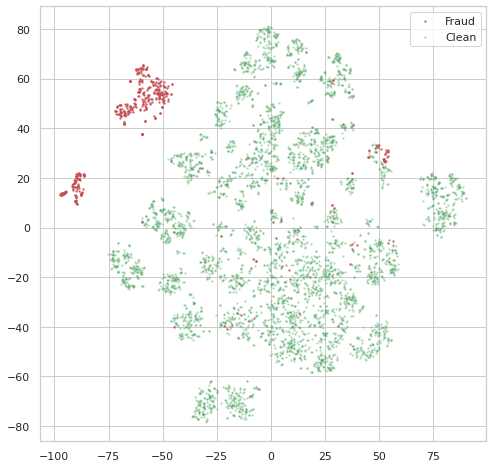

In [11]:
tsne_scatter(features, labels, dimensions=2)

In [12]:
fraud.shape
clean.shape

(284315, 30)

## Train/ Validate/ Test Split
Autoencoder will only be trained on clean transactions. 
Leftover data will be combined with the fraud set to form out test sample.







In [13]:
print(f"""Shape of the datasets:
clean (rows, cols) = {clean.shape}
fraud (rows, cols) = {fraud.shape}""")

Shape of the datasets:
clean (rows, cols) = (284315, 30)
fraud (rows, cols) = (492, 30)


In [0]:
# shuffle our training set
clean = clean.sample(frac=1).reset_index(drop=True) # frac = fraction of items to return; 1 = all items

# training set: exclusively non-fraud transactions
#TRAINING_SAMPLE = 200,000
X_train = clean.iloc[:TRAINING_SAMPLE].drop('label', axis=1)
X_test = clean.iloc[TRAINING_SAMPLE:].append(fraud).sample(frac=1)

In [15]:
print(f"""Our testing set is composed as follows:

{X_test.label.value_counts()}""")

Our testing set is composed as follows:

0    84315
1      492
Name: label, dtype: int64


In [0]:
from sklearn.model_selection import train_test_split

# train // validate - no labels since they are all clean anyway
X_train, X_validate = train_test_split(X_train, test_size=VALIDATE_SIZE, random_state=RANDOM_SEED)

# manually splitting the labels from the test df
X_test, y_test = X_test.drop('label', axis=1), X_test.label.values

Summary of dataset

In [17]:
print(f"""Shape of the datasets:

training (rows, cols) = {X_train.shape}
validate (rows, cols) = {X_validate.shape}
holdout (rows, cols) = {X_test.shape}""")

Shape of the datasets:

training (rows, cols) = (160000, 29)
validate (rows, cols) = (40000, 29)
holdout (rows, cols) = (84807, 29)


## Normalizing & Standardising

Feature normalization/ data standadization is used to center and normalise the data by subtracting the man and dividing by the variance; this is usually done after train test split, else you'll be introducing future information into the training set - data leakage. Preform normalization over training data then test data, both using mean and variance of training variables.

Feature normalization, making sure data is normally distributed is usually helpful for stochastic gradient descent to converged more effectively.

** Notable points: Normalizing worked on autoencoders but not on VAEs. Normalizing dataset affects the clustering of the latent representation which is plotted after training the model.



In [0]:
# from sklearn.preprocessing import Normalizer, MinMaxScaler
# from sklearn.pipeline import Pipeline

# # configure our pipeline
# pipeline = Pipeline(steps=[('normalizer', Normalizer()),
#                      ('scaler', MinMaxScaler())])

In [0]:
# # fitting pipeline
# # get normalization parameters by fitting to the training data
# pipeline.fit(X_train)

In [0]:
# # Applying transformations with acquired parameters
# # transform the training and validation data with these parameters

# X_train_transformed = pipeline.transform(X_train)
# X_validate_transformed = pipeline.transform(X_validate)

## Model

In [0]:
# ref: https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,1)
# z = z_mean + sqrt(var) * epsilon

import tensorflow as tf
from tensorflow.keras import backend as K

def sampling_z(args):
  """Reparameterization trick by sampling from an isotropic unit Gaussian.
  
  # Arguments
      args (tensor): mean and log of variance of Q(z|X)

  # Returns
      z (tensor): sampled latent vector
  """
  
  z_mean, z_log_var = args
  batch = K.shape(z_mean)[0]
  dim = K.int_shape(z_mean)[1]

  # by default, random_normal has mean = 0 and std = 1.0
  epsilon = K.random_normal(shape=(batch, dim))
  return z_mean + K.exp(0.5 * z_log_var) * epsilon      # basically creating the distribution of z, Q(z|X)

In [0]:
# network parameter
original_dim = X_train.shape[1]

input_shape = (original_dim, )
intermediate_dim = [50, 25] 
batch_size = 32
latent_dim = 2
epochs = 1000

In [0]:
from tensorflow.keras.utils import plot_model

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 29)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           1500        encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           1275        dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            52          dense_1[0][0]                    
____________________________________________________________________________________________

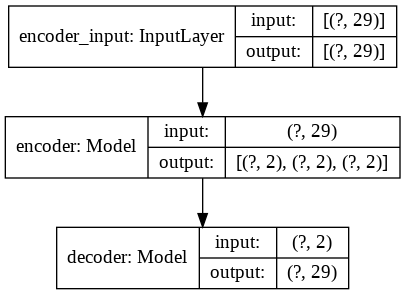

In [24]:
# VAE model = encoder + decoder

# build encoder model: Q(z|X)
inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
x = tf.keras.layers.Dense(intermediate_dim[0], activation='tanh')(inputs)
x = tf.keras.layers.Dense(intermediate_dim[1], activation='relu')(x)
# x = tf.keras.layers.Dense(intermediate_dim[2], activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that 'output_shape' isn't necessary with the TensorFlow backend
z = tf.keras.layers.Lambda(sampling_z, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])  # takes in z_mean, z_log_var and return z, using function sampling_z

# instantiate encoder model
encoder = tf.keras.Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)

# build decoder model: P(X|z)
latent_inputs = tf.keras.Input(shape=(latent_dim, ), name='z_sampling')
x = tf.keras.layers.Dense(intermediate_dim[1], activation='tanh')(latent_inputs)
x = tf.keras.layers.Dense(intermediate_dim[0], activation='relu')(x)
# x = tf.keras.layers.Dense(intermediate_dim[0], activation='relu')(x)
outputs = tf.keras.layers.Dense(original_dim, activation='relu')(x)

# instantiate decoder model
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae')
vae.summary()
plot_model(vae, to_file='vae_model.png', show_shapes=True)

In [0]:
from tensorflow.keras.losses import mse, binary_crossentropy

In [0]:
reconstruction_loss = mse(inputs, outputs)
# reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

In [0]:
# D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
# kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

# E[log P(X|z)]
# reconstruction_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=1)
vae_loss = 0.5*reconstruction_loss + 0.5*kl_loss
vae.add_loss(vae_loss)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0015)
vae.compile(optimizer=optimizer)

## Callbacks


*   Continue as long as the model is reducing the training loss
*   Save only the weights for the model with the lowest validation loss, though
*   Get graphical insights with Tensorboard

In [0]:
# define early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# callbacks argument only takes a list
cb = [early_stop]

Training

In [29]:
history = vae.fit(
    X_train, X_train,
    epochs=epochs,
    callbacks=cb,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_validate,X_validate)
)

Epoch 1/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.3945 - val_loss: 14.0299
Epoch 2/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.2189 - val_loss: 14.0372
Epoch 3/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.1932 - val_loss: 13.9873
Epoch 4/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.1694 - val_loss: 13.9710
Epoch 5/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.1618 - val_loss: 13.9421
Epoch 6/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.1494 - val_loss: 13.9359
Epoch 7/1000
5000/5000 [==============================] - 16s 3ms/step - loss: 14.1406 - val_loss: 13.9230
Epoch 8/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.1444 - val_loss: 13.9312
Epoch 9/1000
5000/5000 [==============================] - 17s 3ms/step - loss: 14.1364 - val_loss: 13.9295
Epoch 10/1000
5000/5000 [============

In [0]:
# transform the test set with the pipeline fitted to the training set
# X_test_transformed = pipeline.transform(X_test)

## Visualising the latent space

In [31]:
fraud = X_test[y_test==1]
clean = X_test[y_test==0][:len(fraud)*RATIO_TO_FRAUD]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)), np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

print(f'Clean transactions downsampled from {len(X_test[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation[2].shape)

Clean transactions downsampled from 84,315 to 4,920.
Shape of latent representation: (5412, 2)


In [32]:
lr = latent_representation[2]
lr

array([[ 1.1623492 , -1.1089864 ],
       [ 1.7945821 , -3.0818994 ],
       [-0.18305635, -0.4728596 ],
       ...,
       [-0.0695976 ,  0.35086578],
       [-0.42245492, -0.7530286 ],
       [-0.5671282 ,  1.0923948 ]], dtype=float32)

In [0]:
if latent_dim == 2:
  x, y = lr[:, 0], lr[:, 1]

else:
  x, y, z = lr[:, 0], lr[:, 1], lr[:, 2]

In [0]:
from mpl_toolkits.mplot3d import Axes3D

def scatter_plot(features, labels, dimensions=2):
  if dimensions not in (2,3):
    raise ValueError("""tsne_scatter can only plot in 2d or 3d 
    (What are you? An alien that can visualise >3d?). Make sure the "dimensions" argument is in (2, 3)""")

  # initialising the plot
  fig, ax = plt.subplots(figsize=(8, 8))
  # plotting
  plt.scatter(x[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
  plt.scatter(x[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')

  # counting dimensions
  if dimensions == 3:
    ax = fig.add_subplot(111, projection='3d')
    # plotting data
    ax.scatter(x[labels==1], y[labels==1], z[labels==1], marker='o', color='r', s=2, alpha=0.7, label='Fraud')
    ax.scatter(x[labels==0], y[labels==0], z[labels==0], marker='o', color='g', s=2, alpha=0.3, label='Clean') 

  # title labels
  plt.title('Latent Representation')
  plt.legend(loc='best')
  plt.show();

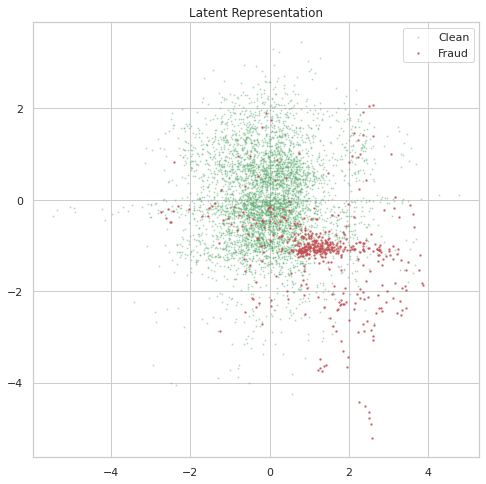

In [35]:
scatter_plot(features, labels, dimensions=latent_dim)

## Calculating VAE outcome using MAD threshold

In [0]:
reconstructions = vae.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error':mse}).reset_index()       # retaining original index of data
error_df['true_class'] = y_test

In [0]:
# modified version of: www.stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def detect_mad_outliers(points, threshold=3.5):  
    
    # calculate the median of the input array
    median = np.median(points, axis=0)
    
    # calculate the absolute difference of each data point to the calculated median
    deviation = np.abs(points - median)
    
    # take the median of those absolute differences
    med_abs_deviation = np.median(deviation)
    
    # 0.6745 is the 0.75th quartile of the standard normal distribution,
    # to which the MAD converges.
    modified_z_score = 0.6745 * deviation / med_abs_deviation
    
    # return as extra information what the original mse value was at which the threshold is hit
    # need to find a way to compute this mathematically, but I'll just use the index of the nearest candidate for now
    idx = (np.abs(modified_z_score - threshold)).argmin()
    threshold_value = points[idx]

    return modified_z_score, threshold_value

In [0]:
mse = mse.to_list()

In [0]:
# adjust this parameter to customise the recall/precision trade-off
Z_SCORE_THRESHOLD = 3

# find the outliers on our reconstructions' mean squared errors
mad_z_scores, threshold_value = detect_mad_outliers(mse, threshold=Z_SCORE_THRESHOLD)
mad_outliers = (mad_z_scores > Z_SCORE_THRESHOLD).astype(int)

In [41]:
anomalies = len(mad_outliers[mad_outliers==True])
total_trades = len(y_test)

print(f"""MAD Z-score > {Z_SCORE_THRESHOLD} is the selected threshold.
I.e. any trade with a mean squared reconstruction error >= {threshold_value:,.2f} is flagged.

This results in {anomalies:,} detected anomalies, or {anomalies/total_trades*100:.2f}% out of {total_trades:,} trades reported.""")

MAD Z-score > 3 is the selected threshold.
I.e. any trade with a mean squared reconstruction error >= 1.56 is flagged.

This results in 5,851 detected anomalies, or 6.90% out of 84,807 trades reported.


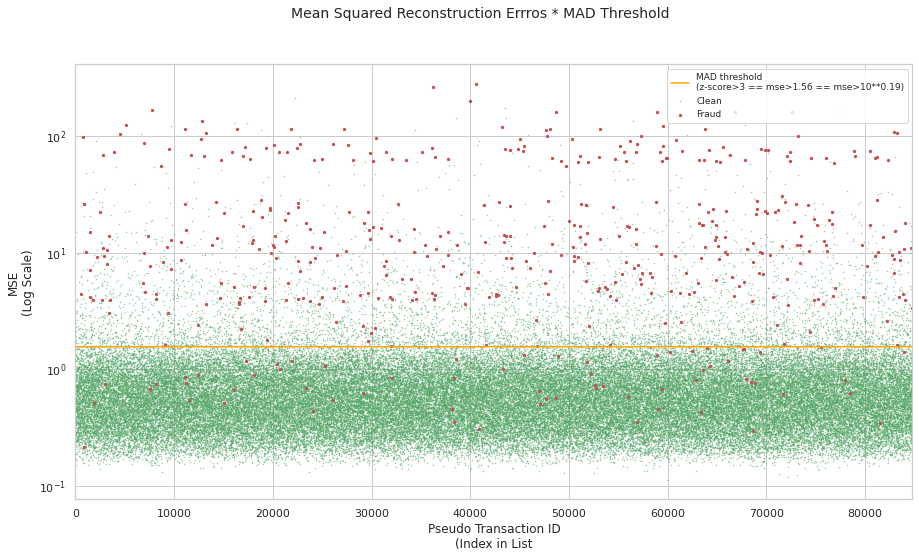

In [42]:
# so we can plot separately and thus customise for each class
# (we have to retain the index number as the pseudo transaction id)

data = np.column_stack((range(len(mse)), mse))   # arrays of ([range(len(mse)), mse], .....) == arrays of (index, mse)

# scatter's x and y
clean_x, clean_y = data[y_test==0][:, 0], data[y_test==0][:, 1]    # index, mse
fraud_x, fraud_y = data[y_test==1][:, 0], data[y_test==1][:, 1]

# instantiate new figure
fig, ax = plt.subplots(figsize=(15, 8))

# plot reconstruction errors
ax.scatter(clean_x, clean_y, s=0.25, color='g', alpha=0.6, label='Clean')
ax.scatter(fraud_x, fraud_y, s=5.00, color='r', alpha=1, label = 'Fraud')

# MAD threshold line
ax.plot([threshold_value for i in range(len(mse))], color='orange',
        linewidth=1.5,
        label=f'MAD threshold\n(z-score>{Z_SCORE_THRESHOLD} == mse>{threshold_value:.2f} == mse>10**{np.log10(threshold_value):.2f})'
)

# change scale to log & limit x-axis range
ax.set_yscale('log')
ax.set_xlim(0, len(mse))

# title & labels
fig.suptitle('Mean Squared Reconstruction Errros * MAD Threshold', fontsize=14)
ax.set_xlabel('Pseudo Transaction ID\n(Index in List')
ax.set_ylabel('MSE\n(Log Scale)')

# orange legend for threshold value
ax.legend(loc = 'upper right', prop={'size': 9})

# display
fig.show();


In [0]:
from sklearn.metrics import confusion_matrix

# get (mis)classification
cm = confusion_matrix(y_test, mad_outliers) # row: actual, col: predicted

In [44]:
cm

array([[78891,  5424],
       [   65,   427]])

In [45]:
recall = cm[1,1] / (cm[1,0] + cm[1,1]) * 100                            # recall: tp / (tp+fn)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) * 100                      # precision: tp / (tp+fp)
f1_score = 2 * (precision * recall) / (precision + recall) / 100

print(f'The classifications using the MAD method with threshold={Z_SCORE_THRESHOLD} are as follows:\n{cm}\n')
print(f'Fraud caught successfully (recall):\n{cm[1,1]} / ({cm[1,0]} + {cm[1,1]}) = {recall:.2f}%')
print(f'Precision:\n{cm[1,1]} / ({cm[1, 1]} + {cm[0,1]}) = {precision:.2f}%')
print(f'F1 Score = {f1_score:.2f}')

The classifications using the MAD method with threshold=3 are as follows:
[[78891  5424]
 [   65   427]]

Fraud caught successfully (recall):
427 / (65 + 427) = 86.79%
Precision:
427 / (427 + 5424) = 7.30%
F1 Score = 0.13
